In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import numpy as np
import pandas as pd
import gzip
import os

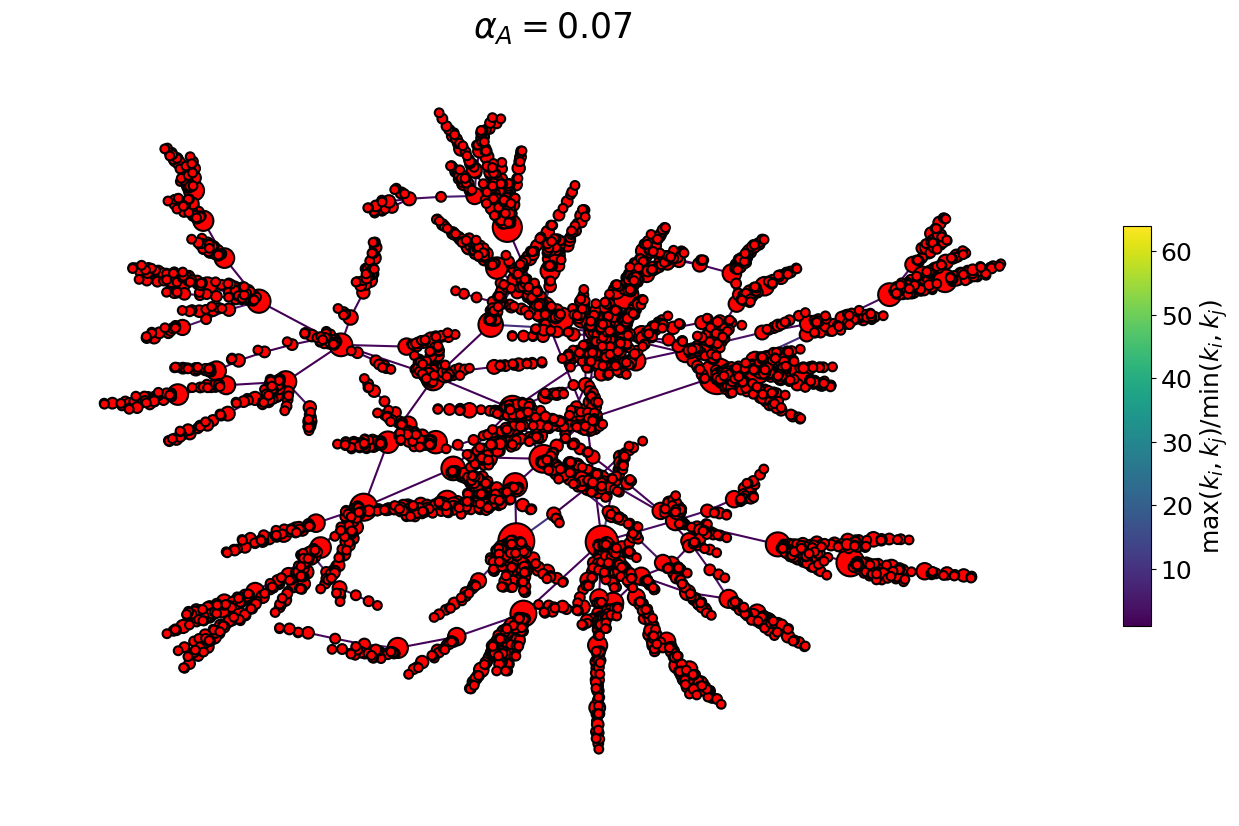

In [20]:

def select_first_graphml_file(N, dim, alpha_a, alpha_g):
    directory = f"../../network/N_{N}/dim_{dim}/alpha_a_{alpha_a:.2f}_alpha_g_{alpha_g:.2f}/gref/"
    # Itera sobre os arquivos na pasta fornecida
    for file in os.listdir(directory):
        if file.endswith('.graphml'):
            selected_file = file
            #print(selected_file)
            return selected_file
    
    print("Nenhum arquivo .gml.gz encontrado na pasta.")
    return None

def plot_network_distances(N, dim, alpha_a, alpha_g, alpha_g_variable=True):
    dir_graphml = f"../../network/N_{N}/dim_{dim}/alpha_a_{alpha_a:.2f}_alpha_g_{alpha_g:.2f}/gref/"
    file_graphml = select_first_graphml_file(N, dim, alpha_a, alpha_g)
    path = dir_graphml + file_graphml

    G = nx.read_graphml(path)

    pos = {
        n: (float(data['x']), float(data['y']))
        for n, data in G.nodes(data=True)
        if 'x' in data and 'y' in data
    }

    # Afastamento global das posições (mantendo layout relativo)
    scale_factor = 10.0  # quanto maior, mais separação

    # Centraliza e escala
    x_vals, y_vals = zip(*pos.values())
    x_mean = np.mean(x_vals)
    y_mean = np.mean(y_vals)

    for n in pos:
        x, y = pos[n]
        x_centered = x - x_mean
        y_centered = y - y_mean
        pos[n] = (x_centered * scale_factor, y_centered * scale_factor)


    degrees = dict(G.degree())
    node_sizes = [30 + 10 * degrees[n] for n in G.nodes()]

    distances = []
    for u, v in G.edges():
        dist = float(G[u][v].get("distance", 1.0))
        G[u][v]["distance"] = dist
        distances.append(dist)

    log_distances = np.array([
        np.log10(np.clip(float(G[u][v].get("distance", 1.0)), 1e-6, None))    
        for u, v in G.edges()
    ])

    norm_dist = Normalize(vmin=log_distances.min(), vmax=log_distances.max())

    fig, ax = plt.subplots(figsize=(14, 10))

    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color='red',
        edgecolors='black',
        linewidths=1.5,
        ax=ax
    )

    nx.draw_networkx_edges(
        G, pos,
        edge_color=log_distances,
        edge_cmap=cm.viridis,
        edge_vmin=log_distances.min(),
        edge_vmax=log_distances.max(),
        width=1.5,
        ax=ax
    )

    plt.axis("off")

    cax2 = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cb2 = ColorbarBase(cax2, cmap=cm.viridis, norm=norm_dist)
    cb2.set_label(r"$\log_{10}d_{ij}$", fontsize=18)
    cb2.ax.tick_params(labelsize=18)

    ax.set_title(fr"$\alpha_G = {alpha_g}$" if alpha_g_variable else fr"$\alpha_A = {alpha_a}$", fontsize=25)
    path_network = "../../results/network/alpha_g" if alpha_g_variable else "../../results/network/alpha_a"
    os.makedirs(path_network, exist_ok=True)

    plt.savefig(path_network + f"/N_{N}_dim_{dim}_alpha_a_{alpha_a}_alpha_g_{alpha_g}.png", dpi=300, bbox_inches='tight')
    plt.show()

def plot_network_degree_ratio(N, dim, alpha_a, alpha_g, alpha_g_variable=True):
    dir_graphml = f"../../network/N_{N}/dim_{dim}/alpha_a_{alpha_a:.2f}_alpha_g_{alpha_g:.2f}/gref/"
    file_graphml = select_first_graphml_file(N, dim, alpha_a, alpha_g)
    path = dir_graphml + file_graphml

    G = nx.read_graphml(path)

    pos = {
        n: (float(data['x']), float(data['y']))
        for n, data in G.nodes(data=True)
        if 'x' in data and 'y' in data
    }

    # Afastamento global das posições (mantendo layout relativo)
    scale_factor = 100.0  # quanto maior, mais separação

    # Centraliza e escala
    x_vals, y_vals = zip(*pos.values())
    x_mean = np.mean(x_vals)
    y_mean = np.mean(y_vals)

    for n in pos:
        x, y = pos[n]
        x_centered = x - x_mean
        y_centered = y - y_mean
        pos[n] = (x_centered * scale_factor, y_centered * scale_factor)


    degrees = dict(G.degree())
    node_sizes = [30 + 10 * degrees[n] for n in G.nodes()]

    edge_ratios = []
    processed_edges = set()

    for u, v in G.edges():
        if (v, u) in processed_edges:
            continue
        k1, k2 = degrees[u], degrees[v]
        ratio = k1 / k2 if k1 >= k2 else k2 / k1
        edge_ratios.append(ratio)
        processed_edges.add((u, v))

    edge_ratios = np.array(edge_ratios)
    norm_ratio = Normalize(vmin=edge_ratios.min(), vmax=edge_ratios.max())

    fig, ax = plt.subplots(figsize=(14, 10))

    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color='red',
        edgecolors='black',
        linewidths=1.5,
        ax=ax
    )

    nx.draw_networkx_edges(
        G, pos,
        edge_color=edge_ratios,
        edge_cmap=cm.viridis,
        edge_vmin=edge_ratios.min(),
        edge_vmax=edge_ratios.max(),
        width=1.5,
        ax=ax
    )

    plt.axis("off")

    cax2 = fig.add_axes([0.92, 0.3, 0.02, 0.4])
    cb2 = ColorbarBase(cax2, cmap=cm.viridis, norm=norm_ratio)
    cb2.set_label(r"$\max(k_i, k_j) / \min(k_i, k_j)$", fontsize=18)
    cb2.ax.tick_params(labelsize=18)

    ax.set_title(fr"$\alpha_G = {alpha_g}$" if alpha_g_variable else fr"$\alpha_A = {alpha_a}$", fontsize=25)
    path_network = "../../results/network/degree_ratio_alpha_g" if alpha_g_variable else "../../results/network/degree_ratio"
    os.makedirs(path_network, exist_ok=True)

    plt.savefig(path_network + f"/N_{N}_dim_{dim}_alpha_a_{alpha_a}_alpha_g_{alpha_g}.png", dpi=300, bbox_inches='tight')
    plt.show()


N = 5000
dim = 1
alpha_a = 0.07
alpha_ag_f = 2.00
#plot_network_distances(N, dim, alpha_a, alpha_ag_f, alpha_g_variable=False)
plot_network_degree_ratio(N, dim, alpha_a, alpha_ag_f, alpha_g_variable=False)
# N = 500
# dim = 2
# alpha_ag_f = 2.0
# alpha_g_v = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
# alpha_a_v = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
# for alpha_a in alpha_a_v:
#     plot_network_distances(N, dim, alpha_a, alpha_ag_f, alpha_g_variable=False)

# for alpha_g in alpha_g_v:
    
#     plot_network_distances(N, dim, alpha_ag_f, alpha_g, alpha_g_variable=True)


In [ ]:
N = 500
dim = 2
alpha_ag_f = 2.0
alpha_g_v = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
alpha_a_v = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

def create_repository(N, dim, alpha_a, alpha_g):
    repo_path = f"../../network/N_{N}/dim_{dim}/alpha_a_{alpha_a:.2f}_alpha_g_{alpha_g:.2f}/gref"
    os.makedirs(repo_path, exist_ok=True)

def select_first_gml_gz_file(N, dim, alpha_a, alpha_g):
    directory = f"../../network/N_{N}/dim_{dim}/alpha_a_{alpha_a:.2f}_alpha_g_{alpha_g:.2f}/gml/"
    # Itera sobre os arquivos na pasta fornecida
    for file in os.listdir(directory):
        if file.endswith('.gml.gz'):
            selected_file = file
            #print(selected_file)
            return selected_file
    
    print("Nenhum arquivo .gml.gz encontrado na pasta.")
    return None



def convert_gmlgz_to_gexf(N, dim, alpha_a, alpha_g):
    dir = f"../../network/N_{N}/dim_{dim}/alpha_a_{alpha_a:.2f}_alpha_g_{alpha_g:.2f}/gml/"
    dir_gref = f"../../network/N_{N}/dim_{dim}/alpha_a_{alpha_a:.2f}_alpha_g_{alpha_g:.2f}/gref/"
    file_input = select_first_gml_gz_file(N, dim, alpha_a, alpha_g)
    name_wt_extension = file_input[:-7]
    gml_file = dir + file_input
    
    # Descompactar o .gml.gz
    decompressed_path = gml_file.replace(".gz", "")
    with gzip.open(gml_file, "rt", encoding="utf-8", errors="ignore") as f_in, open(decompressed_path, "w", encoding="utf-8") as f_out:
        for line in f_in:
            f_out.write(line.replace("(", "").replace(")", ""))  # Remove parênteses

    # Ler o GML
    G = nx.read_gml(decompressed_path)

    # Criar novo grafo
    G_clean = nx.Graph()

    # Adicionar nós com posições
    for n, data in G.nodes(data=True):
        x = float(data.get("graphics", {}).get("x", 0.0))
        y = float(data.get("graphics", {}).get("y", 0.0))
        z = 0.0

        G_clean.add_node(int(n))
        G_clean.nodes[int(n)]["x"] = x
        G_clean.nodes[int(n)]["y"] = y
        G_clean.nodes[int(n)]["z"] = z
        G_clean.nodes[int(n)]["viz"] = {"position": {"x": x, "y": y, "z": z}}

    # Adicionar arestas com distância
    for u, v, data in G.edges(data=True):
        u_int, v_int = int(u), int(v)
        dist = float(data.get("distance", 1.0))
        G_clean.add_edge(u_int, v_int, distance=dist)

    # Salvar como GEXF
    output_gexf_path = dir_gref + name_wt_extension + ".gexf"
    nx.write_gexf(G_clean, output_gexf_path)
    print(f"GEXF salvo em: {output_gexf_path}")

for alpha_a in alpha_a_v:
    create_repository(N, dim, alpha_a, alpha_ag_f)
    convert_gmlgz_to_gexf(N, dim, alpha_a, alpha_ag_f)

for alpha_g in alpha_g_v:
    create_repository(N, dim, alpha_ag_f, alpha_g)
    convert_gmlgz_to_gexf(N, dim, alpha_ag_f, alpha_g)

GEXF salvo em: ../../network/N_500/dim_2/alpha_a_0.00_alpha_g_2.00/gref/gml_918814880.gexf
GEXF salvo em: ../../network/N_500/dim_2/alpha_a_1.00_alpha_g_2.00/gref/gml_764030081.gexf
GEXF salvo em: ../../network/N_500/dim_2/alpha_a_2.00_alpha_g_2.00/gref/gml_161527347.gexf
GEXF salvo em: ../../network/N_500/dim_2/alpha_a_3.00_alpha_g_2.00/gref/gml_1552225388.gexf
GEXF salvo em: ../../network/N_500/dim_2/alpha_a_4.00_alpha_g_2.00/gref/gml_1160063346.gexf
GEXF salvo em: ../../network/N_500/dim_2/alpha_a_5.00_alpha_g_2.00/gref/gml_1017623713.gexf
GEXF salvo em: ../../network/N_500/dim_2/alpha_a_6.00_alpha_g_2.00/gref/gml_1290688440.gexf
GEXF salvo em: ../../network/N_500/dim_2/alpha_a_7.00_alpha_g_2.00/gref/gml_2111305239.gexf
GEXF salvo em: ../../network/N_500/dim_2/alpha_a_8.00_alpha_g_2.00/gref/gml_1959447075.gexf
GEXF salvo em: ../../network/N_500/dim_2/alpha_a_2.00_alpha_g_1.00/gref/gml_824274616.gexf
GEXF salvo em: ../../network/N_500/dim_2/alpha_a_2.00_alpha_g_2.00/gref/gml_16152734

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import pandas as pd
import gzip

# Caminho de entrada e saída
input_path = "/home/junior/Documents/SpatialPreferential/network/N_40000/dim_2/alpha_a_2.00_alpha_g_4.00/gml/gml_456472383.gml.gz"
output_path = input_path.replace(".gml", "_corrigido.gml").replace(".gz", "")

# Corrigir as linhas com "(x)" para apenas "x"
with gzip.open(input_path, "rt", encoding="utf-8", errors="ignore") as f_in, open(output_path, "w", encoding="utf-8") as f_out:
    for line in f_in:
        line_corrigida = line.replace("(", "").replace(")", "")
        f_out.write(line_corrigida)



# Caminho original (usado apenas como valor de referência)
gml_path = "/home/junior/Documents/SpatialPreferential/network/N_40000/dim_2/alpha_a_2.00_alpha_g_4.00/gml/gml_456472383_corrigido.gml"

# Carrega a rede (substitua o caminho abaixo por gml_path se estiver executando localmente)
G = nx.read_gml(gml_path)
# Exemplo: considerar hubs os nós com grau > 90% do grau máximo
# Suponha que 'hubs' é uma lista com os índices dos nós mais conectados



# Calcula o grau dos nós
degrees = dict(G.degree())
max_deg = max(degrees.values())
norm_deg = {n: degrees[n] / max_deg for n in G.nodes()}

# Tamanhos e cores dos nós proporcionais ao grau
node_sizes = [30 + 100 * norm_deg[n] for n in G.nodes()]
node_colors = [cm.plasma(norm_deg[n]) for n in G.nodes()]

# Distâncias nas arestas
distances = []
for u, v in G.edges():
    dist = G[u][v].get("distance", 1.0)
    G[u][v]["distance"] = dist
    distances.append(dist)

distances = np.array(distances)
norm = Normalize(vmin=distances.min(), vmax=distances.max())
edge_colors = [cm.viridis(norm(G[u][v]["distance"])) for u, v in G.edges()]



# Define limiar para considerar um nó como hub

hubs = [n for n, d in G.degree() if d >= 0.8*max(dict(G.degree()).values())]
# Lista para armazenar conexões dos hubs
hub_links = []

# Percorre todas as arestas
for u, v, data in G.edges(data=True):
    if u in hubs or v in hubs:
        hub_links.append({
            "hub": u if u in hubs else v,
            "site": v if u in hubs else u,
            "distance": data.get("distance", None)
        })

# Cria o DataFrame
df_hub_links = pd.DataFrame(hub_links)
hubs_v = df_hub_links["hub"].unique()
hubs_v


FileNotFoundError: [Errno 2] No such file or directory: '/home/junior/Documents/SpatialPreferential/network/N_40000/dim_2/alpha_a_2.00_alpha_g_4.00/gml/gml_456472383.gml.gz'

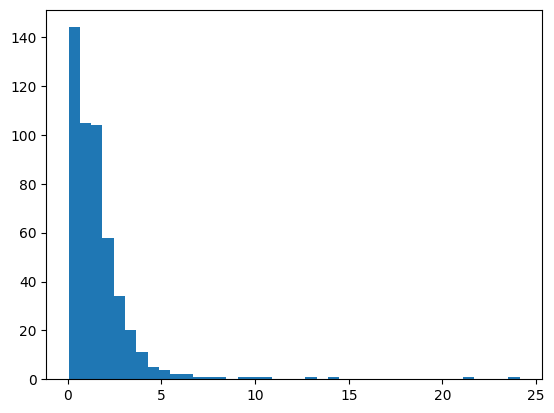

In [72]:
# Caminho original (usado apenas como valor de referência)
gml_path = "/home/junior/Documents/SpatialPreferential/network/N_500/dim_3/alpha_a_2.00_alpha_g_2.00/gml/gml_1413284977_corrigido.gml"

# Carrega a rede (substitua o caminho abaixo por gml_path se estiver executando localmente)
G = nx.read_gml(gml_path)

# Calcula o grau dos nós
degrees = dict(G.degree())
max_deg = max(degrees.values())
norm_deg = {n: degrees[n] / max_deg for n in G.nodes()}

# Tamanhos e cores dos nós proporcionais ao grau
node_sizes = [30 + 100 * norm_deg[n] for n in G.nodes()]
node_colors = [cm.plasma(norm_deg[n]) for n in G.nodes()]

# Distâncias nas arestas
distances = []
for u, v in G.edges():
    dist = G[u][v].get("distance", 1.0)
    G[u][v]["distance"] = dist
    distances.append(dist)
plt.hist(distances, bins=40)
plt.show()


Arquivo corrigido salvo em: /home/junior/Documents/SpatialPreferential/network/N_1000/dim_2/alpha_a_3.00_alpha_g_2.00/gml/gml_300254478_corrigido.gml
